In [13]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode

load_dotenv()

True

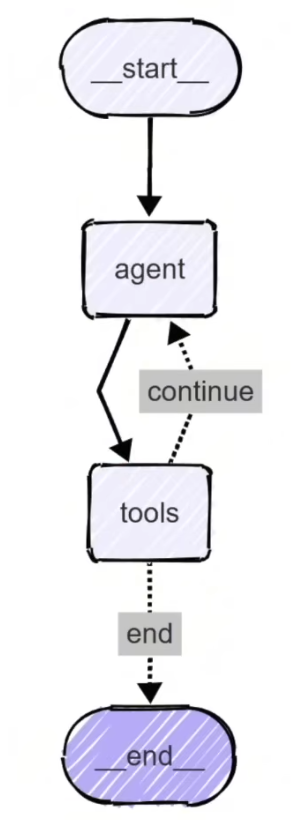

In [2]:
document_content = ""

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

@tool
def update(content: str) -> str:
    """ update the document with the provided content """
    global document_content
    document_content = content
    return "Doc content has been updated successfully, current content: " + document_content

@tool
def save(filename: str) -> str:
    """ save the document to a text file and finish the process 
    Args:
        filename (str): name of the text file
    """
    global document_content
    
    if not filename.endswith(".txt"):
        return "Filename must end with .txt"
        
    try:
        with open(filename, "w") as f:
            f.write(document_content)
        return "Document has been saved successfully to " + filename
    except Exception as e:
        return "Failed to save document: " + str(e)

tools = [update, save]

model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7).bind_tools(tools)

In [5]:
system_prompt = SystemMessage(content=f"""
You are a skillful and helpful drafter assistant that helps drafting documents. 
You are doing to help the user update and modify documents.

- If the use wants to update or modify content, use the `update` tool with the complete updated content.
- If the user wants to save and finish, you need to use the `save` tool.
- Make sure to always show the current document state after modifications.

The current document content is: {document_content}
""")

In [16]:
def draft_agent(state: AgentState) -> AgentState:
    
    if not state["messages"]:
        user_input = "I am ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("what would to like to do with the document?")
        print("User 😙: ", user_input)
        user_message = HumanMessage(content=user_input)
    
    all_messaages = [system_prompt] + list(state["messages"]) + [user_message]
    response = model.invoke(all_messaages)

    print("Assistant 👾: ", response.content)
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": state["messages"] + [user_message, response]}


def should_continue(state: AgentState) -> str:
    """determines if we should continue or end the conversation"""
    if not state["messages"]:
        return "continue"

    for message in reversed(state["messages"]):
        if (isinstance(message, ToolMessage)) and "saved" in message.content.lower() and "document" in message.content.lower():
            return "end"
        
    return "continue"


def print_messages(messages):
    """func to print messages in more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print("Tool result 👩🏻\u200d🦽: ", {message.content})  

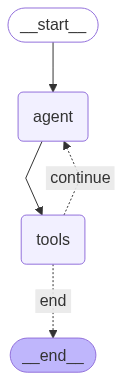

In [17]:
graph = StateGraph(AgentState)
graph.add_node("agent", draft_agent)

graph.add_edge(START, "agent")

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.add_edge("agent", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "end": END,
        "continue": "agent",
    }
)
app = graph.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
def run_document_agent():
    state = {"messages": []}
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    print("\n - - -- --- - - DRAFT FINISHED  - - -- --- - -")

if __name__ == "__main__":
    run_document_agent()

Assistant 👾:  The current document is empty. Please provide the content you would like to create.
User 😙:  lets draft a email to tom says that I cannot make it today
Assistant 👾:  
🔧 USING TOOLS: ['update']
Tool result 👩🏻‍🦽:  {'Doc content has been updated successfully, current content: Dear Tom,\n\nI hope this message finds you well. I regret to inform you that I will not be able to make it today. I apologize for any inconvenience this may cause.\n\nThank you for your understanding.\n\nBest regards,\n[Your Name]'}
User 😙:  
Assistant 👾:  The email draft to Tom stating that you cannot make it today has been created. Is there anything else you would like to update or modify in the document?
Tool result 👩🏻‍🦽:  {'Doc content has been updated successfully, current content: Dear Tom,\n\nI hope this message finds you well. I regret to inform you that I will not be able to make it today. I apologize for any inconvenience this may cause.\n\nThank you for your understanding.\n\nBest regards,\n[